## What Changed after fine-tuning?

Now, in the same spirit of the last lesson Part 2, we'll see again the model internals and attention matrices behaviour before, and after, the finetuning.

In [ ]:
from transformers import AutoModel, AutoTokenizer

In [ ]:
model_name = 'dbmdz/bert-base-italian-cased'
model_name_ft = 'mpapucci/BertForItaCaseholdClassification'

model = AutoModel.from_pretrained(model_name, output_hidden_states=True, output_attentions=True)
model_ft = AutoModel.from_pretrained(model_name_ft, output_hidden_states=True, output_attentions=True)

tokenizer = AutoTokenizer.from_pretrained(model_name)

In [ ]:
frase_input = """Non va sospesa la determina di Roma Capitale che avrebbe disposto la fornitura dei buoni spesa - quale erogazione di contributi alle persone e/o famiglie in condizione di disagio economico e sociale causato dalla situazione emergenziale in atto, provocata dalla diffusione di agenti virali trasmissibili (Covid -19)."""

tokens = tokenizer.tokenize(frase_input, add_special_tokens=True)
input_ids = tokenizer.encode(frase_input, add_special_tokens=True)

In [ ]:
print("Tokens:", tokens)
print("Token Ids:", input_ids)

Tokens: ['[CLS]', 'Non', 'va', 'sospesa', 'la', 'determina', 'di', 'Roma', 'Capitale', 'che', 'avrebbe', 'disposto', 'la', 'fornitura', 'dei', 'buoni', 'spesa', '-', 'quale', 'ero', '##gazione', 'di', 'contributi', 'alle', 'persone', 'e', '/', 'o', 'famiglie', 'in', 'condizione', 'di', 'disagio', 'economico', 'e', 'sociale', 'causato', 'dalla', 'situazione', 'emerge', '##n', '##ziale', 'in', 'atto', ',', 'provoca', '##ta', 'dalla', 'diffusione', 'di', 'agenti', 'vir', '##ali', 'trasmi', '##ssibili', '(', 'Co', '##vid', '-', '19', ')', '.', '[SEP]']
Token Ids: [102, 313, 430, 22710, 146, 2233, 120, 2097, 28975, 158, 2136, 8663, 146, 9132, 292, 7156, 7192, 179, 1040, 2109, 2077, 120, 7945, 518, 1022, 126, 1927, 177, 4075, 139, 4905, 120, 18067, 2763, 126, 1812, 10130, 511, 1928, 16978, 30880, 2561, 139, 4468, 1307, 14670, 115, 511, 6729, 120, 5757, 5028, 314, 29320, 6675, 249, 834, 2543, 179, 355, 4567, 697, 103]


In [ ]:
import torch

input_ids = torch.tensor([input_ids])

with torch.no_grad():
  outputs = model(input_ids)
  outputs_ft = model_ft(input_ids)

all_hidden_states = outputs["hidden_states"]
all_hidden_states_ft = outputs_ft["hidden_states"]

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [ ]:
last_hidden = all_hidden_states[-1].squeeze()
last_hidden_ft = all_hidden_states_ft[-1].squeeze()
print(last_hidden.shape, last_hidden_ft.shape)

torch.Size([63, 768]) torch.Size([63, 768])


Here we fit the TSNE to the combined data of both models, then we split it again and scatter the two with different colors. Finally, we annotate the data with the tokens.

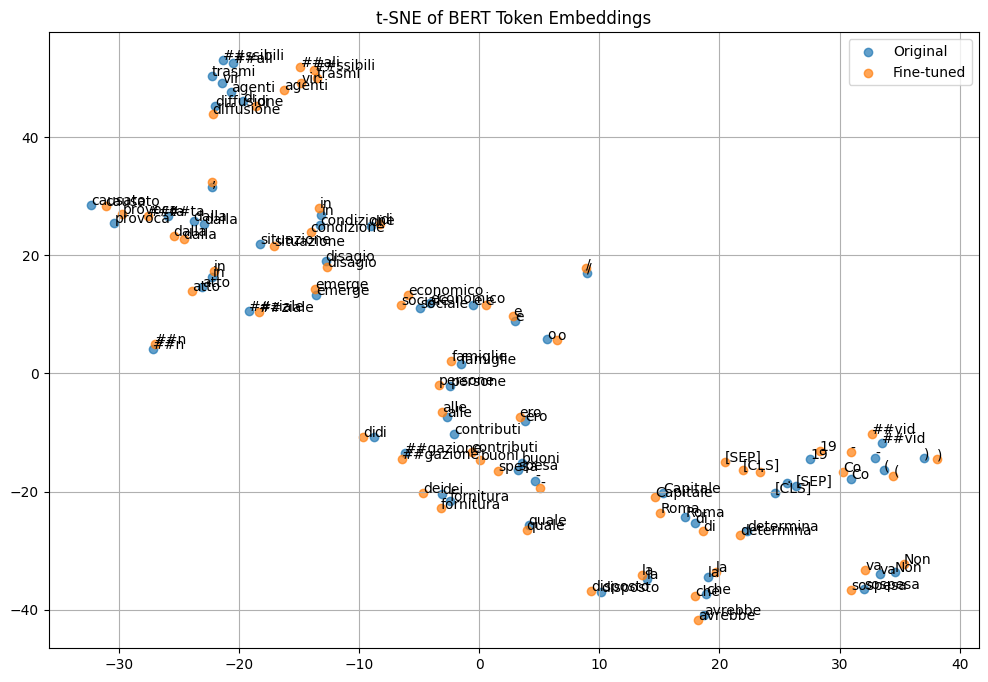

In [ ]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Stack both embeddings vertically
combined_embeddings = np.vstack((last_hidden, last_hidden_ft))

# Fit t-SNE on the combined data
tsne = TSNE(n_components=2, random_state=42, perplexity=5, max_iter=1000)
combined_2d = tsne.fit_transform(combined_embeddings)

# Split back into original and fine-tuned projections
n = len(last_hidden)  # number of tokens
tokens_2d = combined_2d[:n]      # First half: original embeddings
tokens_2d_ft = combined_2d[n:]   # Second half: fine-tuned embeddings

# Plot
plt.figure(figsize=(12, 8))
plt.scatter(tokens_2d[:, 0], tokens_2d[:, 1], label="Original", alpha=0.7)
plt.scatter(tokens_2d_ft[:, 0], tokens_2d_ft[:, 1], label="Fine-tuned", alpha=0.7)

# Annotate points (use the same token labels for both)
for i, token in enumerate(tokens):
    plt.annotate(token, (tokens_2d[i, 0], tokens_2d[i, 1]), fontsize=10)
    plt.annotate(token, (tokens_2d_ft[i, 0], tokens_2d_ft[i, 1]), fontsize=10)

plt.title("t-SNE of BERT Token Embeddings")
plt.legend()
plt.grid(True)
plt.show()

## Attention Matrices
We'll se how the attention matrices behave after fine-tuning. In particular, we'll see how the mean of the heads by layer is changed after the fine-tuning.

In [ ]:
frase_input = "famiglie in condizione di disagio economico e sociale causato dalla situazione emergenziale in atto, provocata dalla diffusione di agenti virali trasmissibili (Covid -19)."

tokens = tokenizer.tokenize(frase_input, add_special_tokens=True)
input_ids = tokenizer.encode(frase_input, add_special_tokens=True)

In [ ]:
input_ids = torch.tensor([input_ids])
print(input_ids.shape)

with torch.no_grad():
  outputs = model(input_ids)
  outputs_ft = model_ft(input_ids)

attention_heads = outputs["attentions"]
attention_heads_ft = outputs_ft["attentions"]

torch.Size([1, 36])


In [ ]:
len(attention_heads) # Layers

12

In [ ]:
attention_heads[0].shape

torch.Size([1, 12, 36, 36])

## First Head for Layer
Let's plot the first head for each layers.

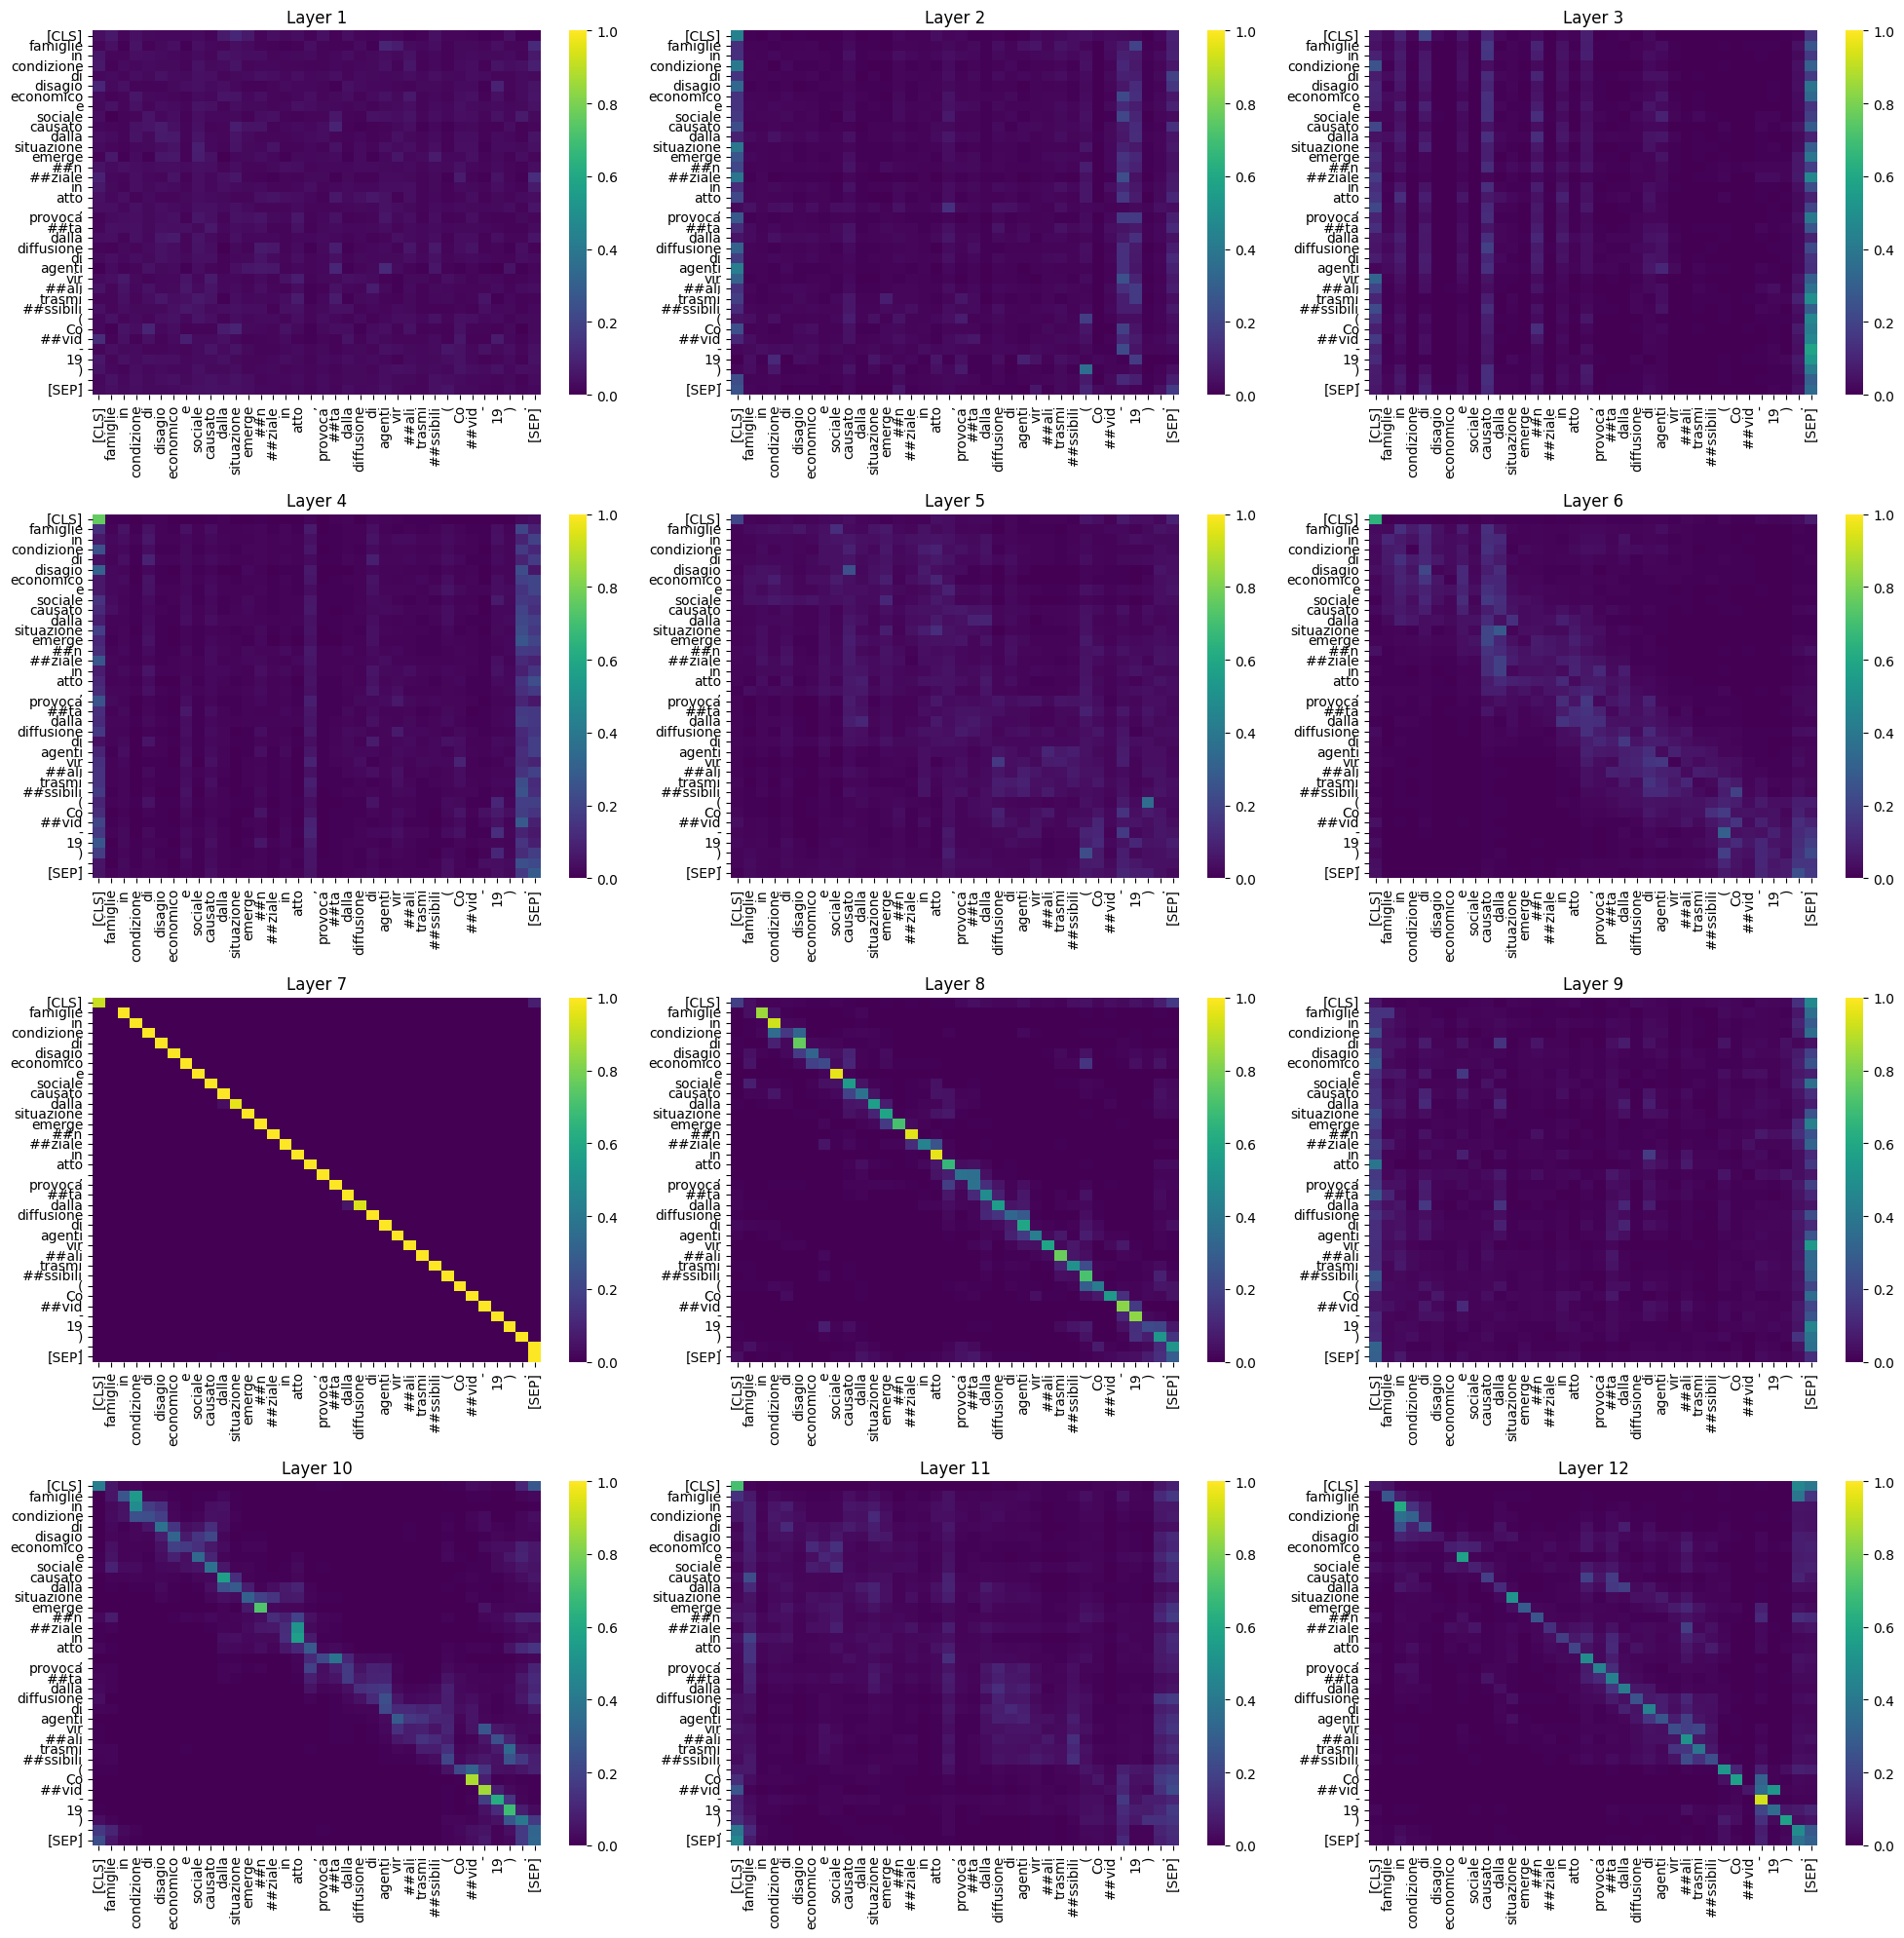

In [ ]:
head = 0 # We decide to look only at the first head of each layer

fig = plt.figure(figsize=(20, 20))

for idx, matrix in enumerate(attention_heads):

  matrix = matrix.squeeze() # We remove the batch_size, since it's one.

  head_matrix = matrix[head] # We look only at one head, obtaining a matrix of n_tokens x n_tokens

  ax = fig.add_subplot(4, 3, idx+1)

  # plot the matrix heatmap
  sns.heatmap(head_matrix, cmap='viridis', yticklabels=tokens, xticklabels=tokens, vmin=0, vmax=1)

  ax.set_title('{} {}'.format("Layer", idx+1))

plt.tight_layout()

plt.show()

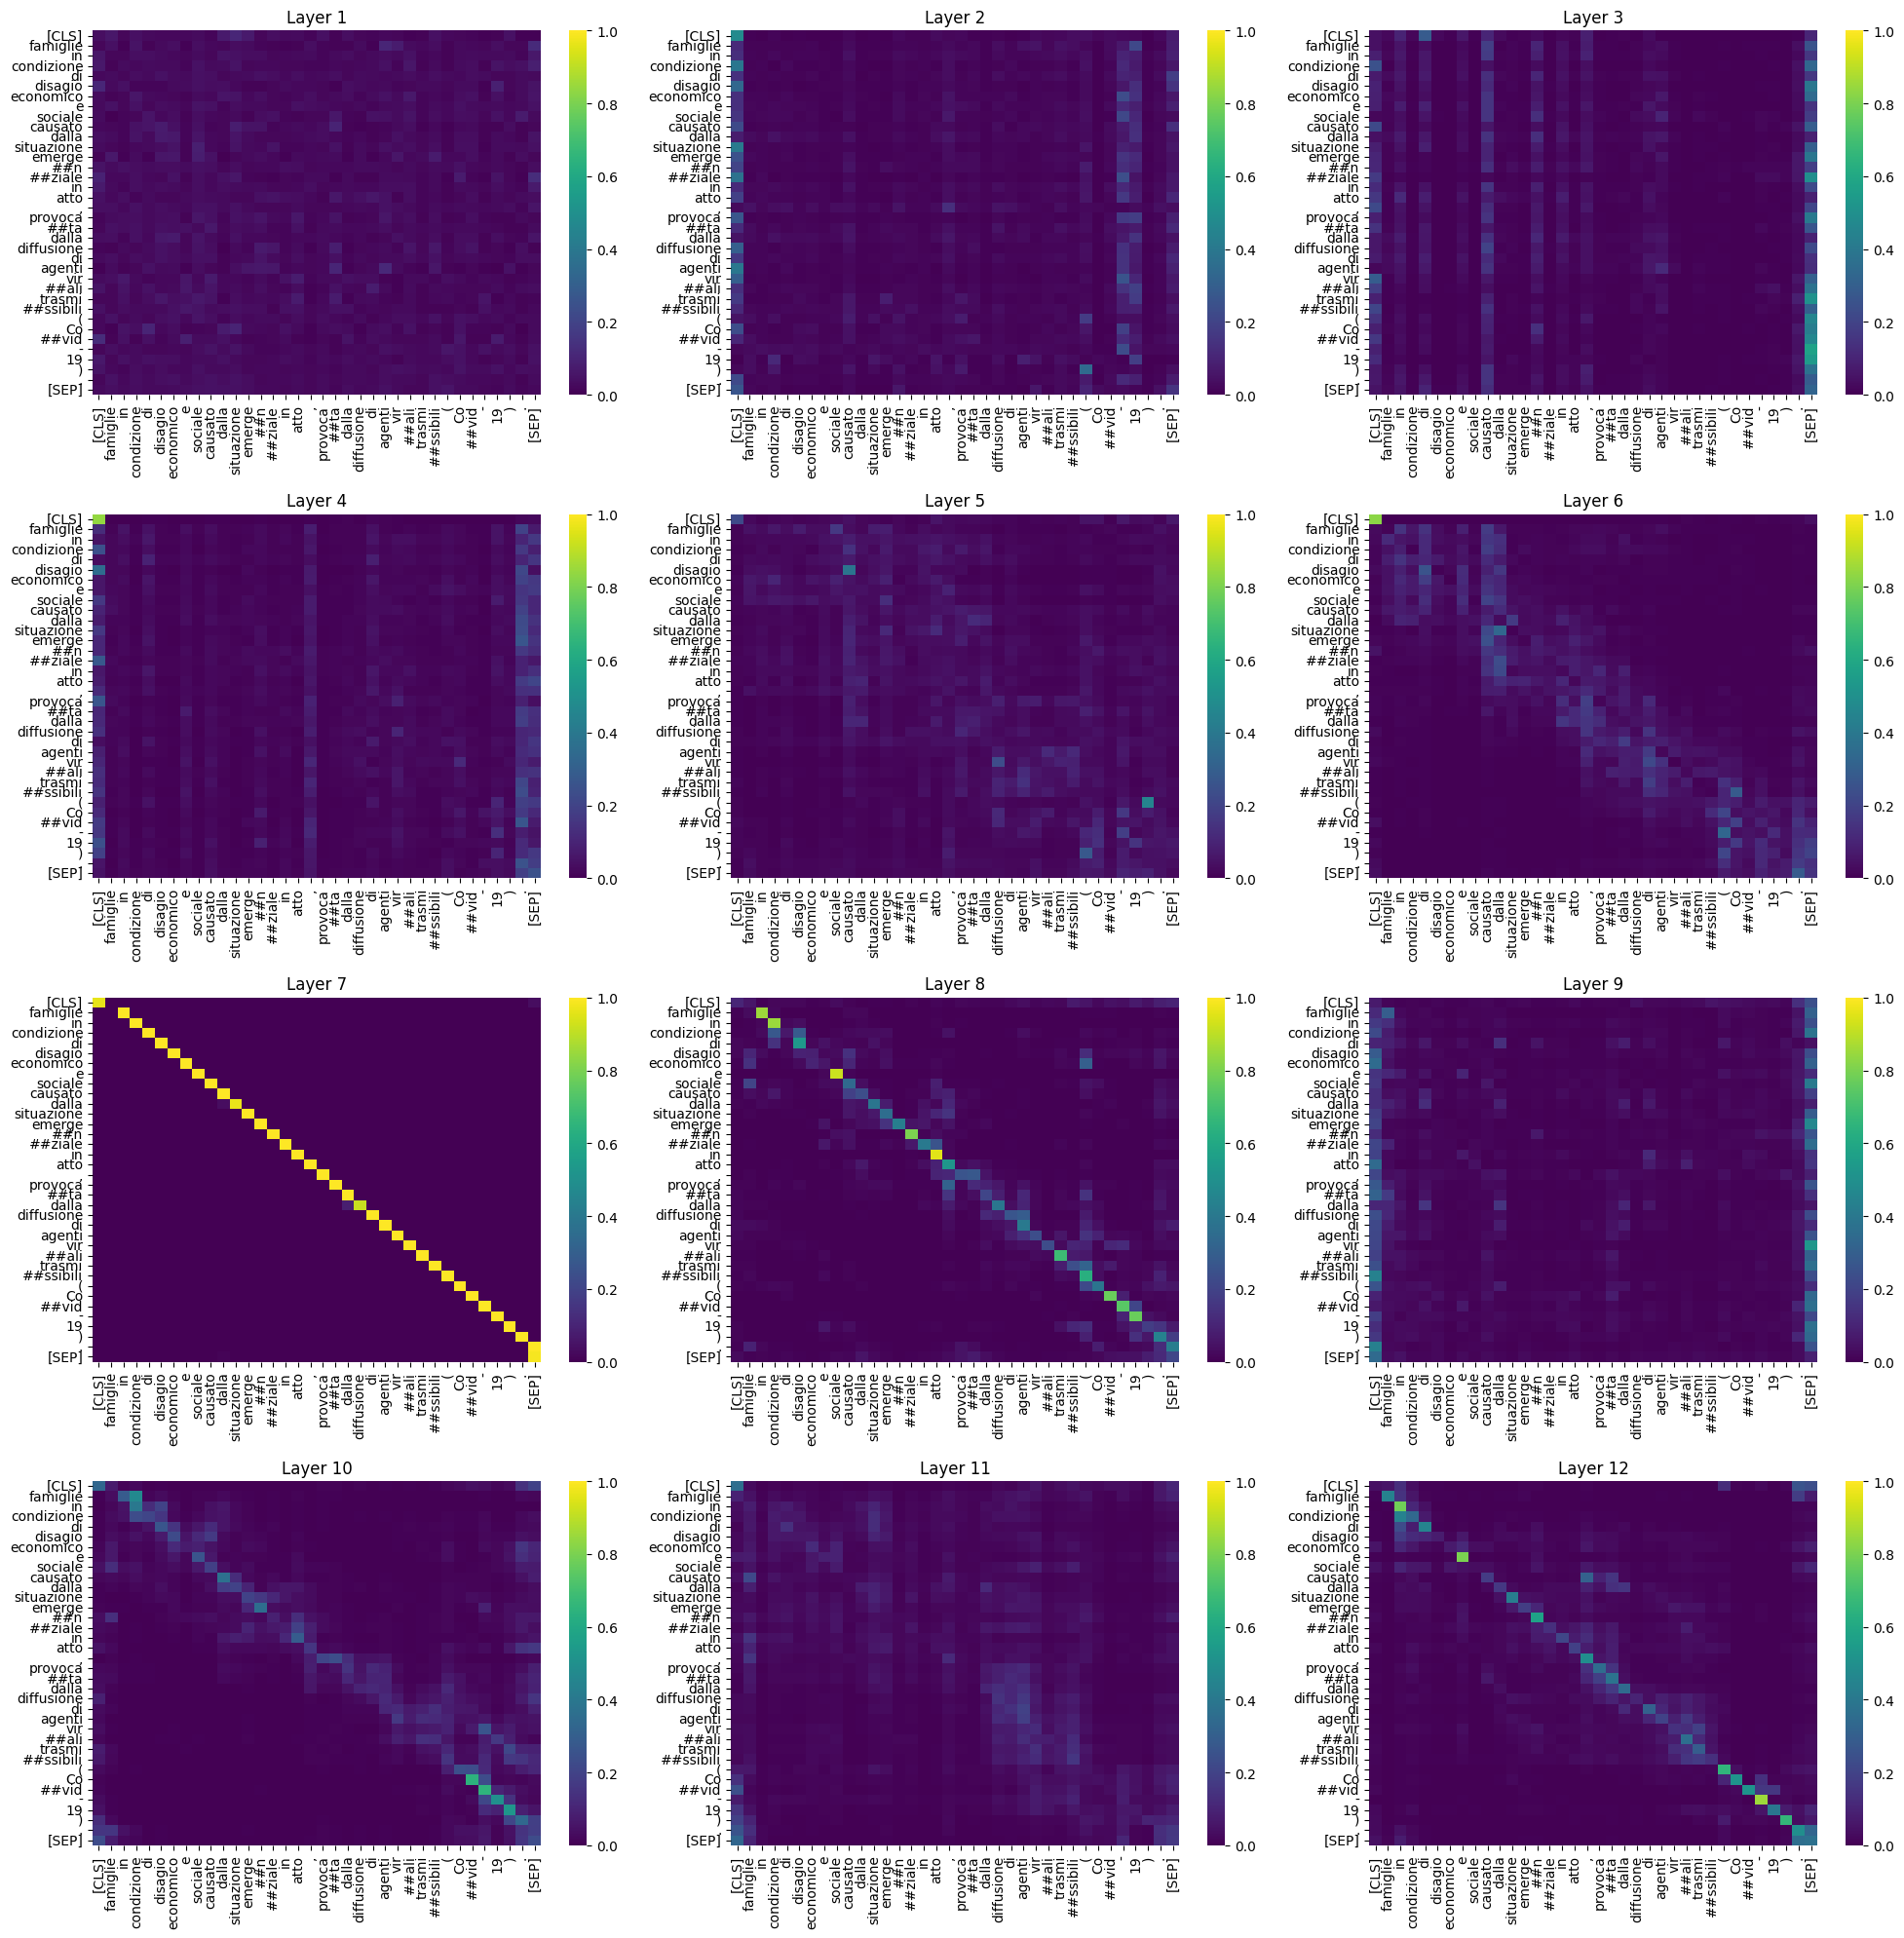

In [ ]:
head = 0 # We decide to look only at the first head of each layer

fig = plt.figure(figsize=(20, 20))

for idx, matrix in enumerate(attention_heads_ft):

  matrix = matrix.squeeze() # We remove the batch_size, since it's one.

  head_matrix = matrix[head] # We look only at one head, obtaining a matrix of n_tokens x n_tokens

  ax = fig.add_subplot(4, 3, idx+1)

  # plot the matrix heatmap
  sns.heatmap(head_matrix, cmap='viridis', yticklabels=tokens, xticklabels=tokens, vmin=0, vmax=1)

  ax.set_title('{} {}'.format("Layer", idx+1))

plt.tight_layout()

plt.show()

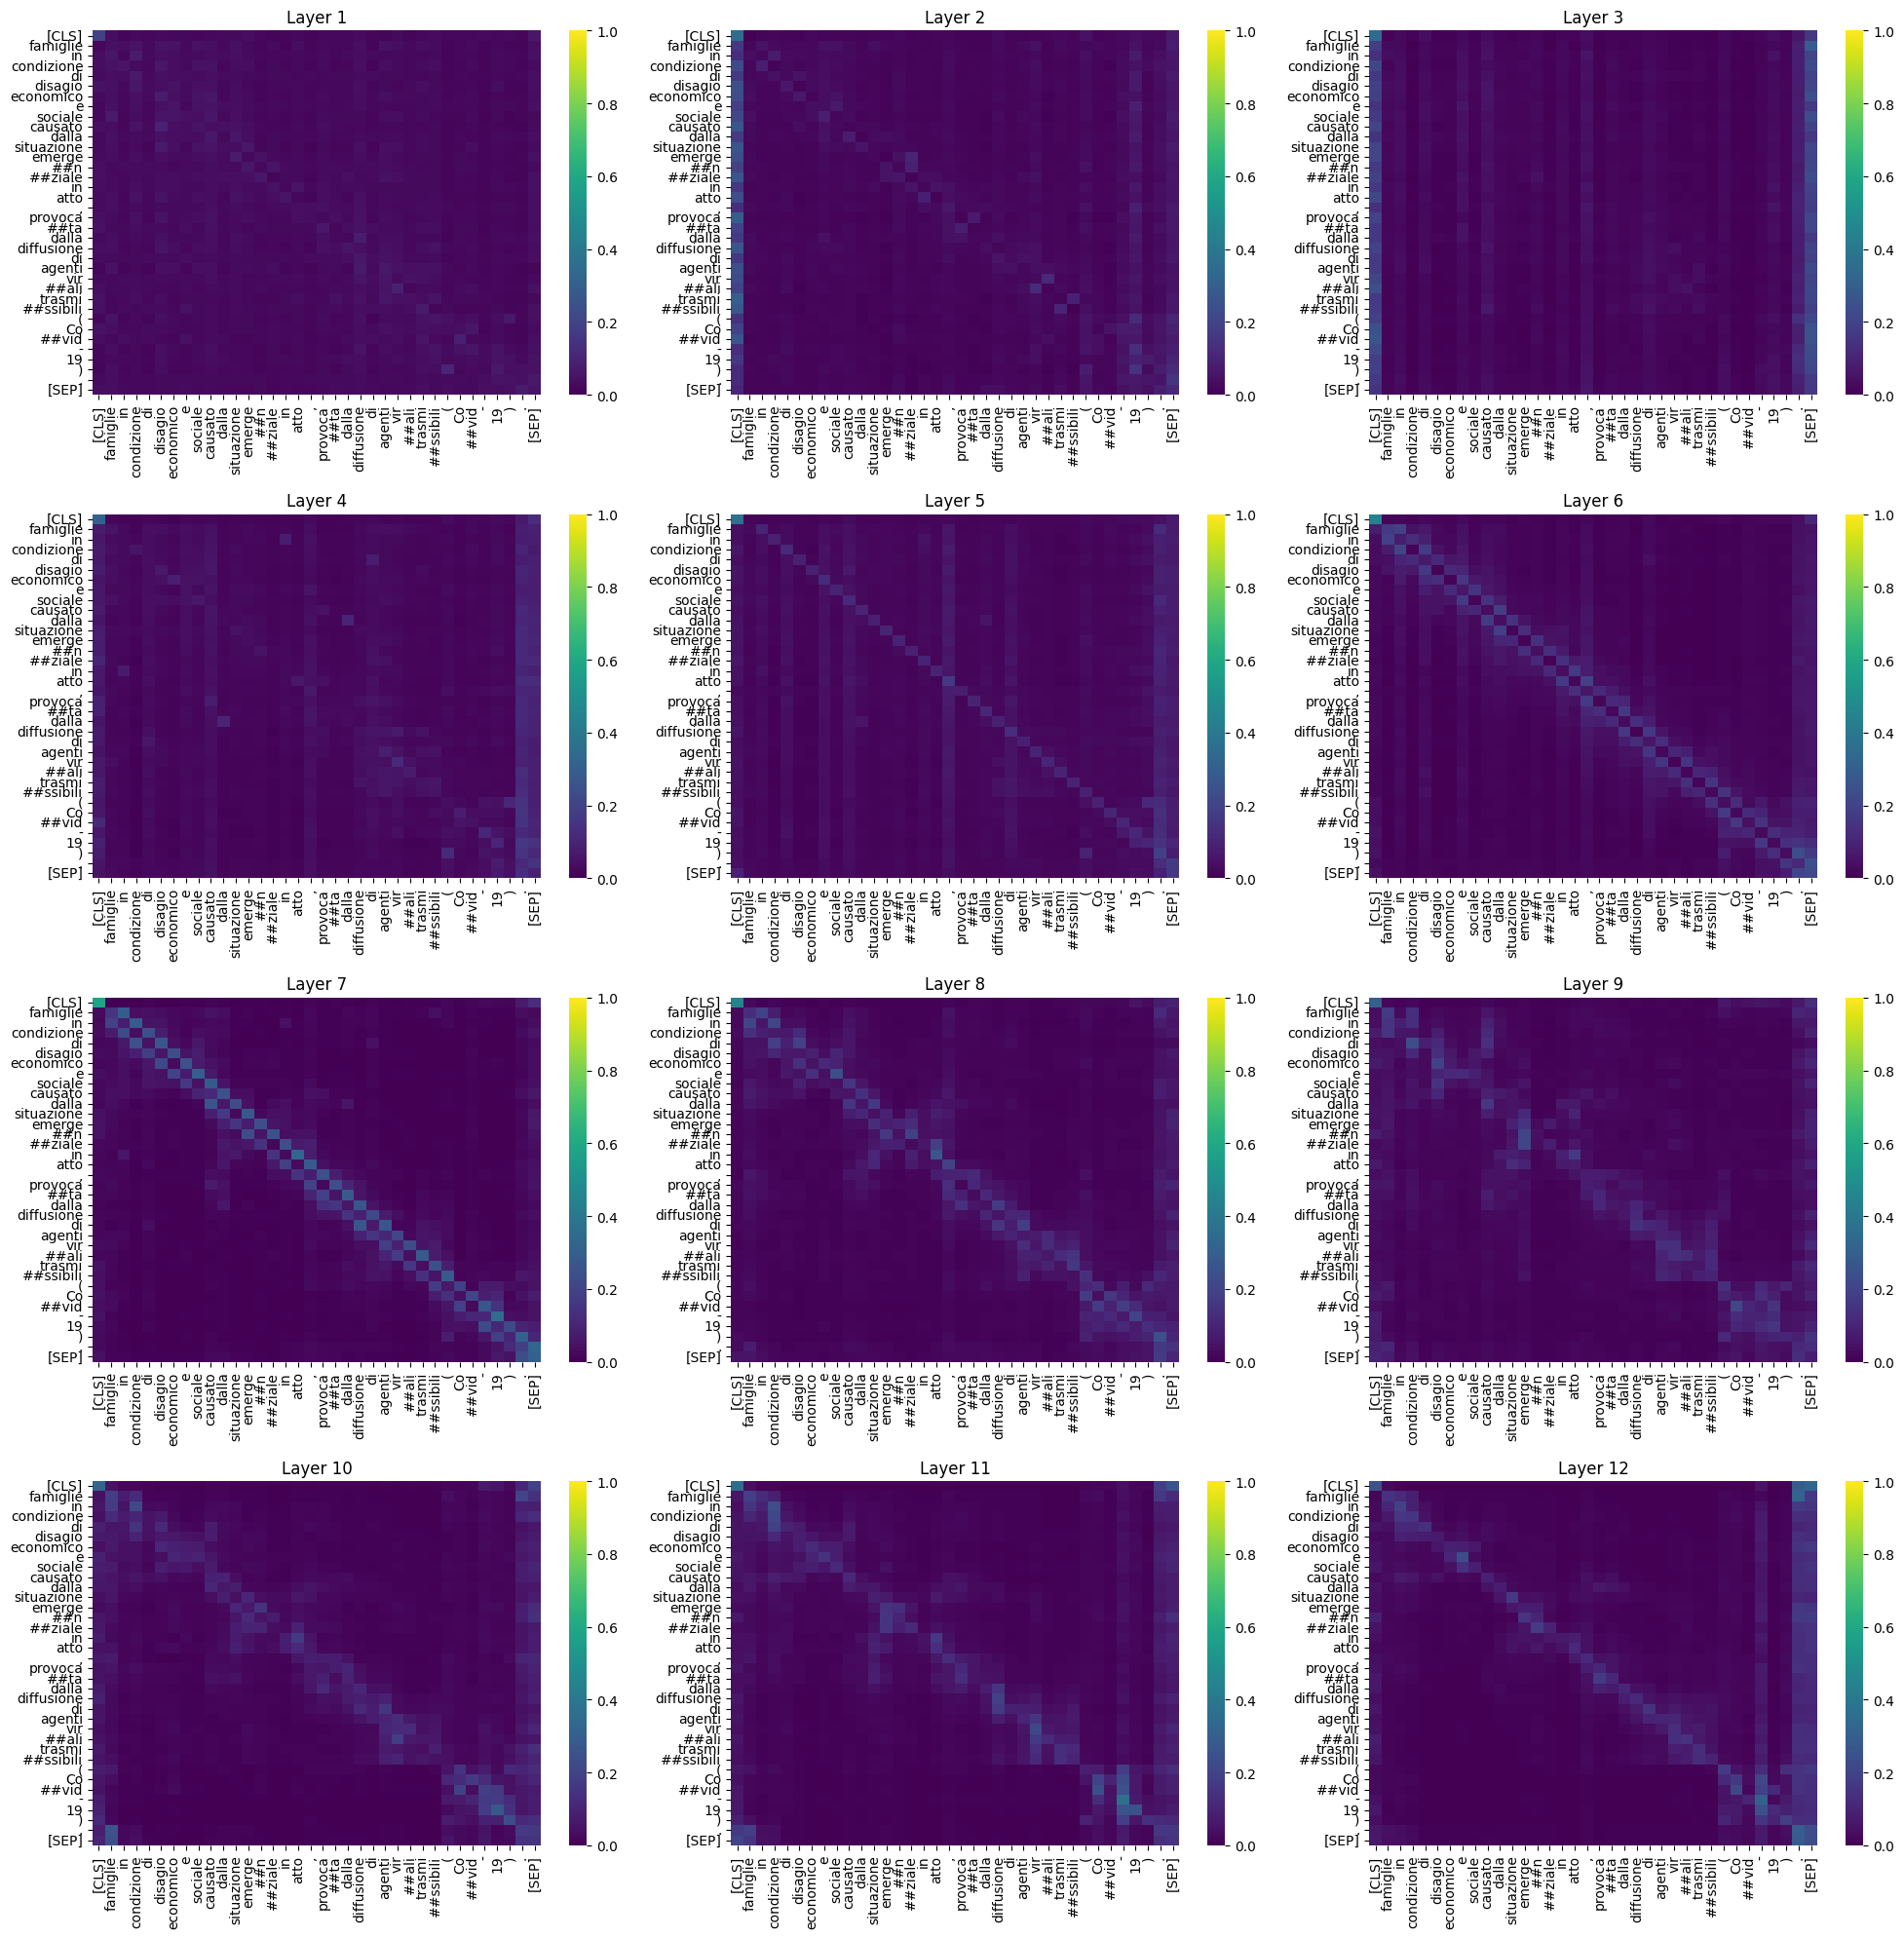

In [ ]:
fig = plt.figure(figsize=(20, 20))

for idx, matrix in enumerate(attention_heads):

  matrix = matrix.squeeze() # We remove the batch_size, since it's one.

  head_matrix = head_matrix = torch.mean(matrix, 0)

  ax = fig.add_subplot(4, 3, idx+1)

  # plot the matrix heatmap
  sns.heatmap(head_matrix, cmap='viridis', yticklabels=tokens, xticklabels=tokens, vmin=0, vmax=1)

  ax.set_title('{} {}'.format("Layer", idx+1))

plt.tight_layout()

plt.show()

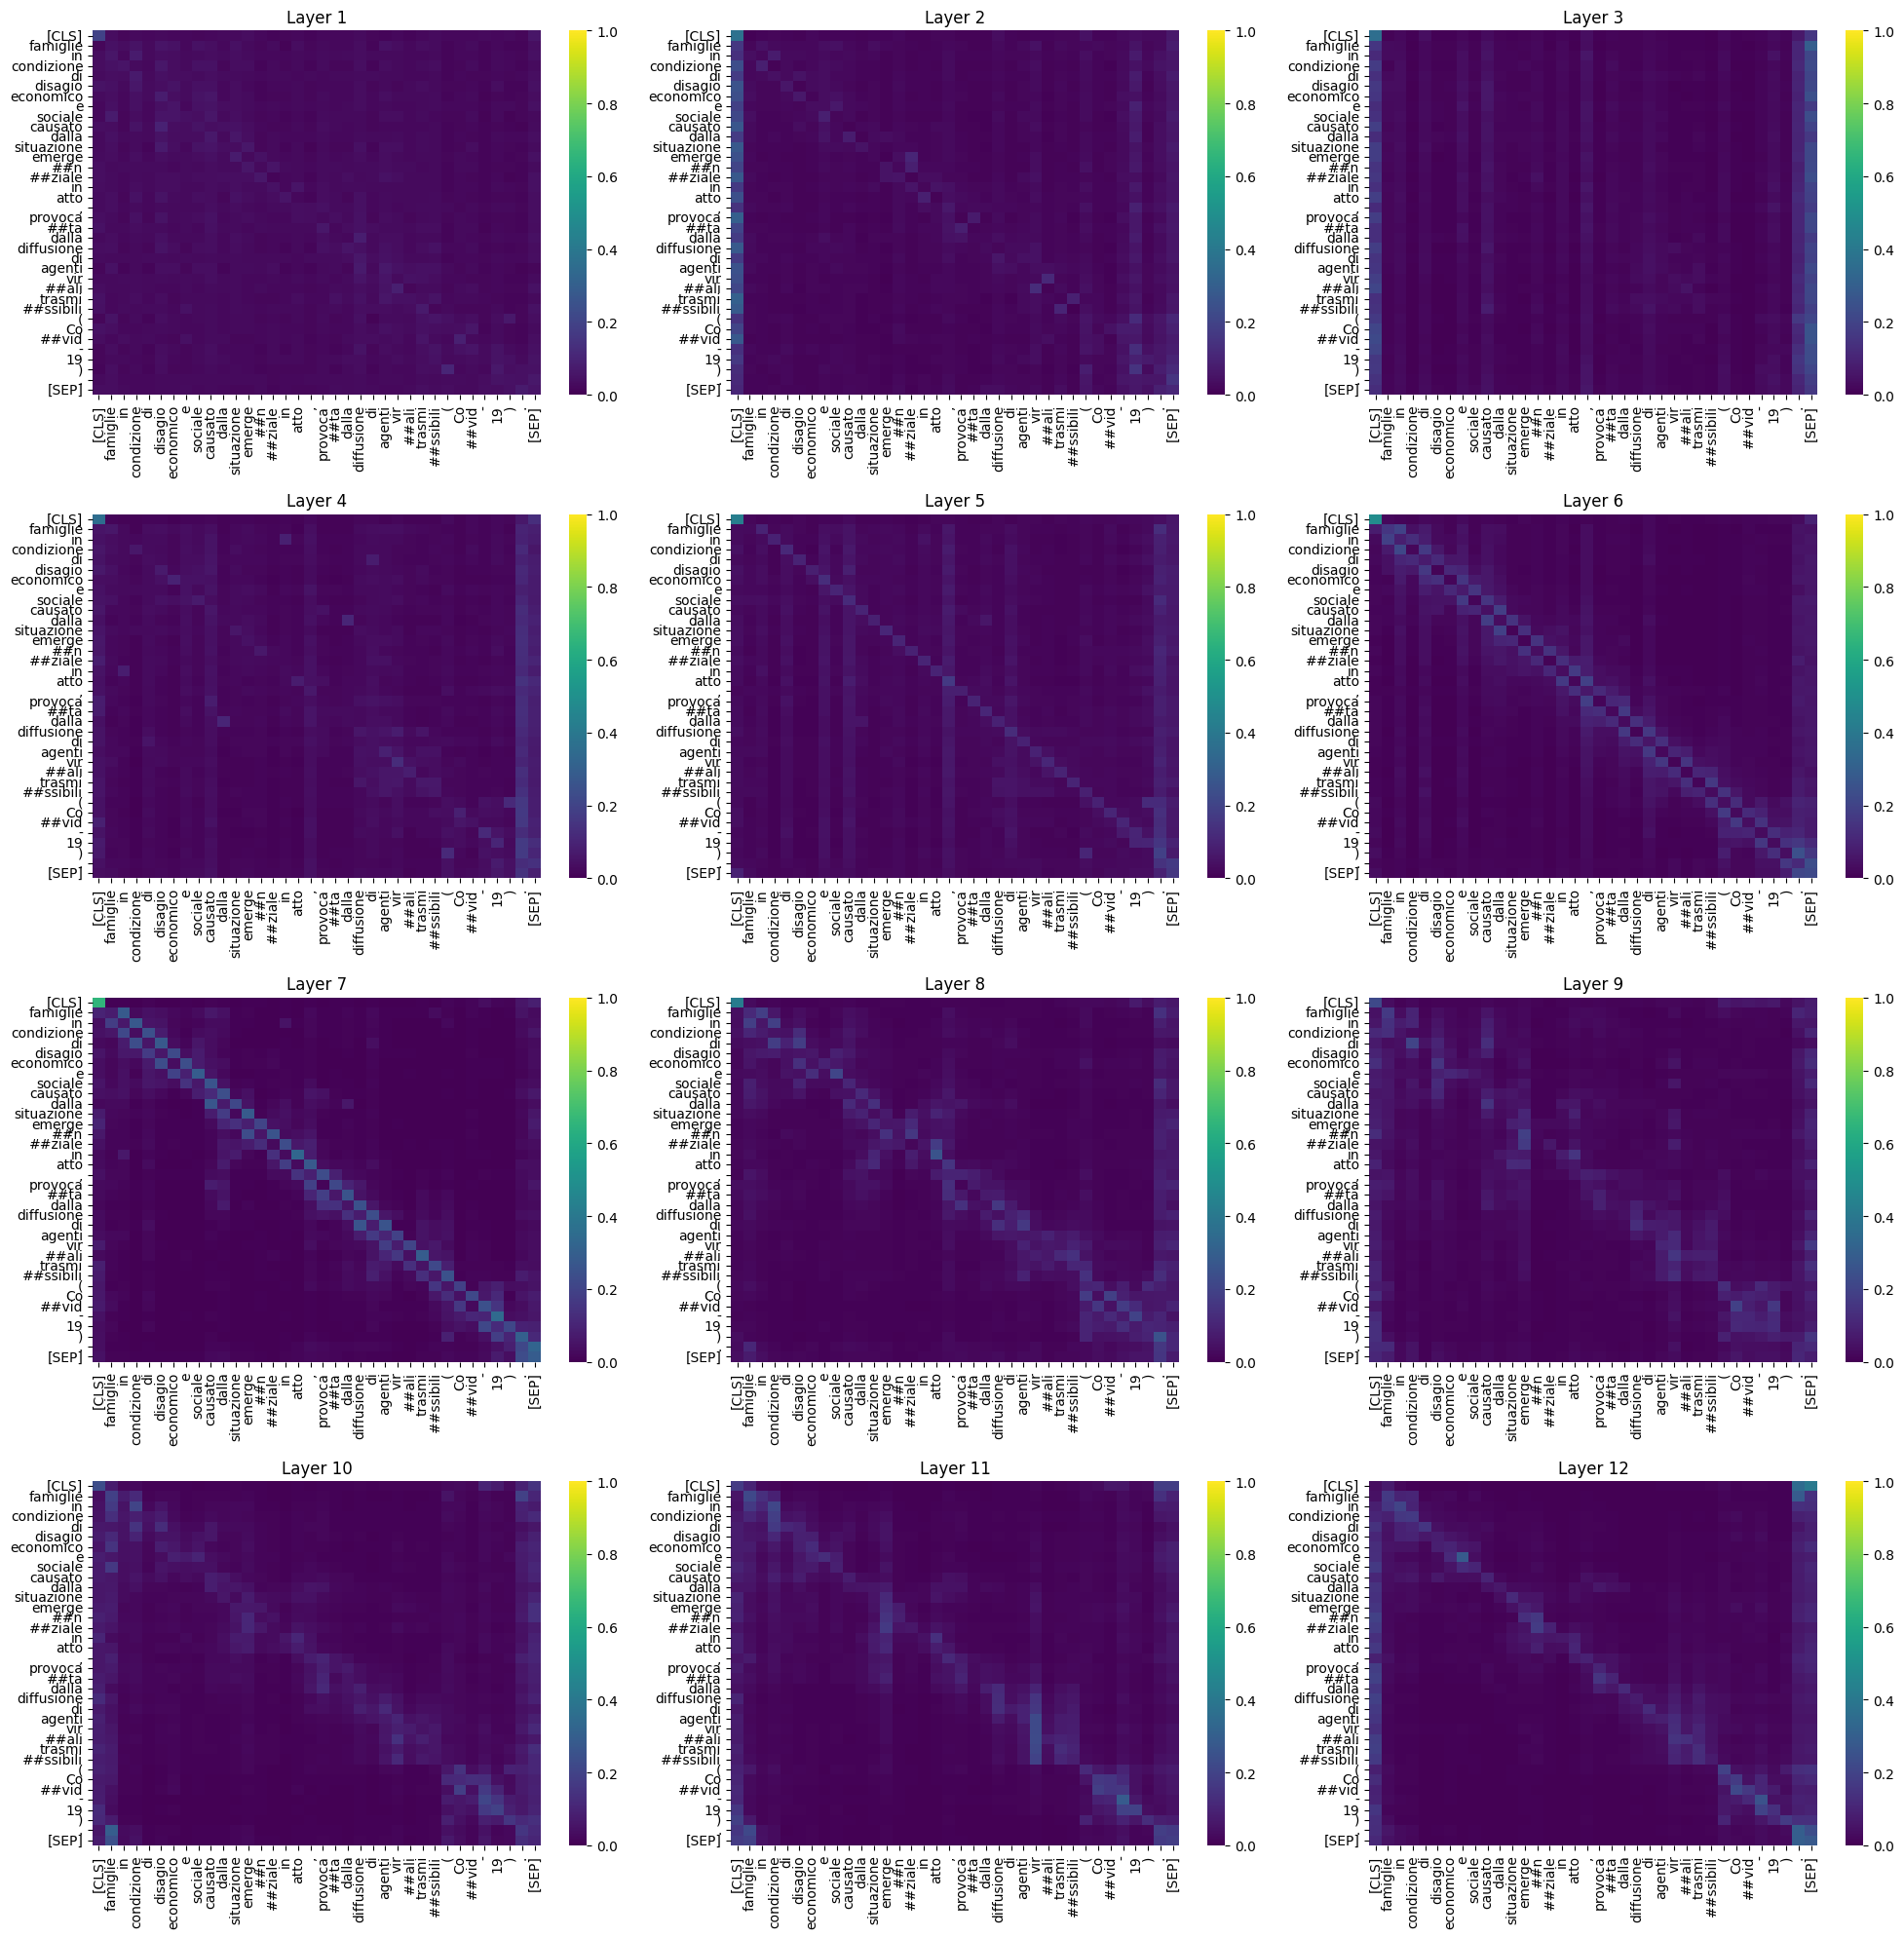

In [ ]:
fig = plt.figure(figsize=(20, 20))

for idx, matrix in enumerate(attention_heads_ft):

  matrix = matrix.squeeze()

  head_matrix = head_matrix = torch.mean(matrix, 0)

  ax = fig.add_subplot(4, 3, idx+1)

  sns.heatmap(head_matrix, cmap='viridis', yticklabels=tokens, xticklabels=tokens, vmin=0, vmax=1)

  ax.set_title('{} {}'.format("Layer", idx+1))

plt.tight_layout()

plt.show()